## Analyzing keio plate 5

This notebook runs the analysis pipeline for the preliminary data for Keio plate 5.

In [1]:
#Import packages
import numpy as np 
import os
import tifffile as tiff
from skimage.io import imread
from skimage.measure import label, regionprops
import scipy
import matplotlib.pyplot as plt
import cPickle as pickle
from SLIP_functions import analyze_well, analyze_plate, segment_SLIP, plot_slip_well, plot_slip_wells
from SLIP_functions import plot_slip_joint_plot, fit_kde, compute_p_values
from SLIP_functions import classify_infections, compute_p_lysis_posterior, compute_MOI_posterior
from keio_names import get_keio_names, pos_to_strain
import seaborn as sns
import pandas as pd
import pymc3 as pm

sns.set_context('notebook', font_scale = 1.1)
sns.set_style('white')
sns.set_style('ticks')

#Activate matplotlib inline
%matplotlib inline

#Define root directory path
root_direc = '/media/vanvalen/fe0ceb60-f921-4184-a484-b7de12c1eea6/keio_screen/07.13.2017/keio_5/'
plate_number = 5

#Define directory path to infection data (all positions)
data_direc = os.path.join(root_direc, 'data')

#Define directory path to control data (all positions)
control_direc = os.path.join(root_direc, 'control')

#Define directory path to where you want to store neural net outputs. 
#mask directories must exist at run time!
mask_direc = os.path.join(root_direc, 'masks')
control_mask_direc = os.path.join(root_direc,'control_masks')

tifffile.py:156: UserWarning: failed to import the optional _tifffile C extension module.
Loading of some compressed images will be slow.
Tifffile.c can be obtained at http://www.lfd.uci.edu/~gohlke/
  "failed to import the optional _tifffile C extension module.\n"
Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 1080 (CNMeM is disabled, cuDNN 5005)


In [2]:
#Define which wells were used
row_control = ['A']
col_control = [1]

row_data = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
col_data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [3]:
#Load saved data
mean_FITC_name = os.path.join(root_direc, 'mean_FITC.pkl')
mean_cherry_name = os.path.join(root_direc, 'mean_cherry.pkl')
mean_FITC = pickle.load(open(mean_FITC_name, 'rb'))
mean_cherry = pickle.load(open(mean_cherry_name, 'rb'))

mean_FITC_control_name = os.path.join(root_direc, 'mean_FITC_control.pkl')
mean_cherry_control_name = os.path.join(root_direc, 'mean_cherry_control.pkl')
mean_FITC_control = pickle.load(open(mean_FITC_control_name, 'rb'))
mean_cherry_control = pickle.load(open(mean_cherry_control_name, 'rb'))

p_values_dict_name = os.path.join(root_direc, 'p_values_dict.pkl')
p_values_dict = pickle.load(open(p_values_dict_name, 'rb'))

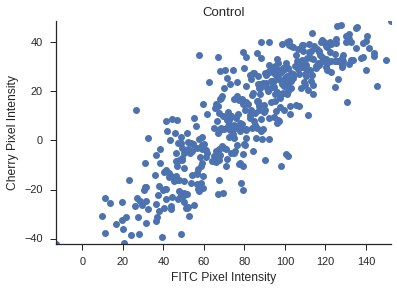

In [4]:
#Plot the data from the control plate
plot_slip_well(mean_FITC_control, mean_cherry_control, well = 'A1', title = 'Control')
sns.despine()

/home/vanvalen/.pyenv/versions/2.7.4/envs/DeepCell/lib/python2.7/site-packages/openpyxl/reader/worksheet.py:310: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


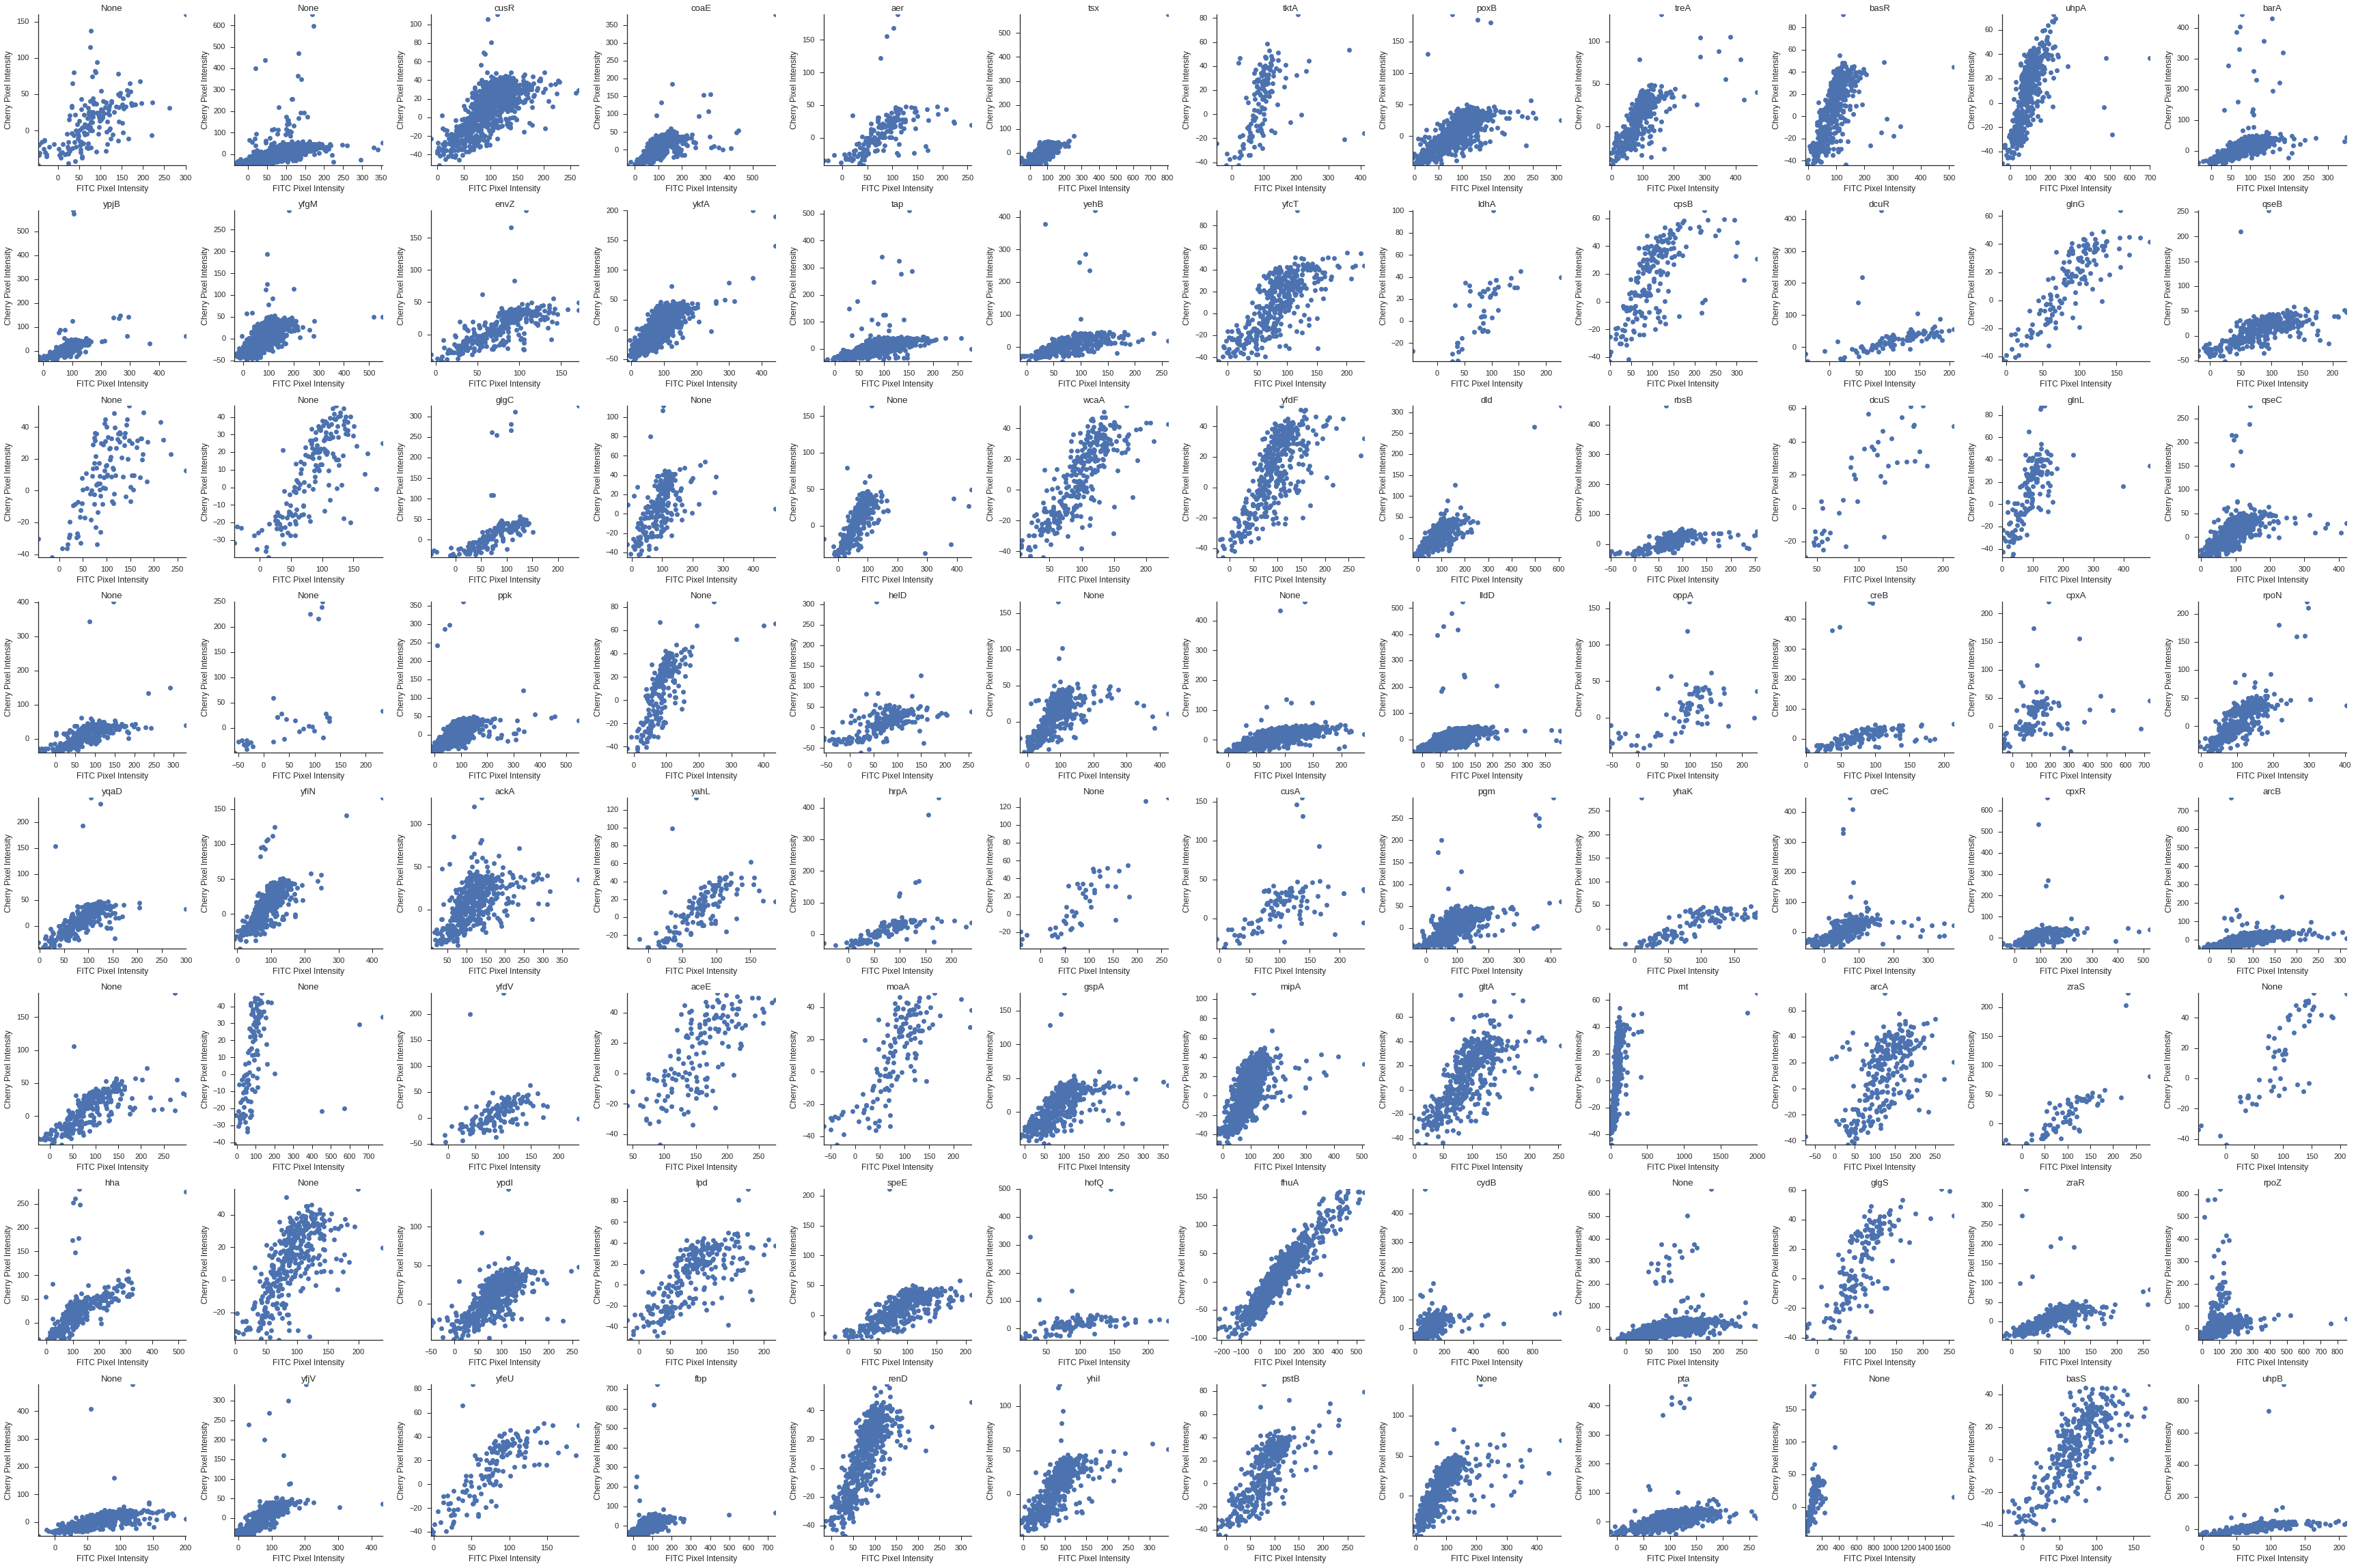

In [5]:
#Plot the scatter plot of intensities
wells = []
titles = []
keio_names_array = get_keio_names()

for row in row_data:
    for col in col_data:
        well = row + str(col)
        wells += [well]
        titles += [pos_to_strain(keio_names_array, 5, well)]
        
plot_slip_wells(mean_FITC, mean_cherry, wells = wells, titles = titles)
sns.despine()

In [6]:
#Print the number of cells in each well
for key in mean_FITC_control.keys():
    print key, len(mean_FITC_control[key])
    
for key in mean_FITC.keys():
    print key, len(mean_FITC[key])

A1 447
G7 822
G6 110
G5 442
G4 252
G3 599
G2 374
G1 378
G9 1488
G8 585
B4 1105
B5 793
B6 367
B7 382
B1 288
B2 1455
B3 317
B8 50
B9 198
E9 114
E8 1068
E5 126
E4 137
E7 106
E6 50
E1 300
E3 563
E2 447
H10 147
H11 330
H12 225
F12 56
F10 280
F11 70
H8 541
H9 778
H2 456
H3 153
H1 545
H6 506
H7 353
H4 1925
H5 578
D10 130
D11 124
D12 402
B12 392
B10 108
B11 145
C9 237
C8 521
C3 163
C2 168
C1 118
C7 397
C6 328
C5 286
C4 246
G12 3128
G11 349
G10 164
F1 253
F2 121
F3 156
F4 152
F5 144
F6 519
F7 1044
F8 499
F9 377
E11 357
E10 385
E12 991
C12 828
C11 155
C10 45
A11 520
A10 518
A12 500
A1 170
A3 898
A2 2893
A5 169
A4 482
A7 148
A6 641
A9 382
A8 793
D8 1621
D9 77
D6 447
D7 816
D4 205
D5 217
D2 34
D3 1180
D1 349


In [7]:
# Fit a KDE estimator to the no infection control
kernel = fit_kde(mean_FITC_control, mean_cherry_control, 'A1')

In [11]:
#Compute the fraction infected in each well and plot
conc_list = []
fraction_infected_list = []
for well in p_values_dict.keys():
    p_value = p_values_dict[well]
    fraction_infected = np.float(np.where(p_value < 0.01)[0].shape[0])/np.float(p_value.shape[0])
    fraction_infected_list += [fraction_infected]
    
    print well, fraction_infected, np.float(np.where(p_value < 0.01)[0].shape[0])

G7 0.323600973236 266.0
G6 0.136363636364 15.0
G5 0.0701357466063 31.0
G4 0.111111111111 28.0
G3 0.0567612687813 34.0
G2 0.0508021390374 19.0
G1 0.269841269841 102.0
G9 0.138440860215 206.0
G8 0.22735042735 133.0
B4 0.0570135746606 63.0
B5 0.0882723833544 70.0
B6 0.0953678474114 35.0
B7 0.0837696335079 32.0
B1 0.0902777777778 26.0
B2 0.0783505154639 114.0
B3 0.0252365930599 8.0
B8 0.06 3.0
B9 0.186868686869 37.0
E9 0.105263157895 12.0
E8 0.10861423221 116.0
E5 0.119047619048 15.0
E4 0.0583941605839 8.0
E7 0.160377358491 17.0
E6 0.16 8.0
E1 0.0533333333333 16.0
E3 0.225577264654 127.0
E2 0.0872483221477 39.0
H10 0.21768707483 32.0
H11 0.00909090909091 3.0
H12 0.102222222222 23.0
F12 0.196428571429 11.0
F10 0.332142857143 93.0
F11 0.185714285714 13.0
H8 0.112754158965 61.0
H9 0.150385604113 117.0
H2 0.0679824561404 31.0
H3 0.0588235294118 9.0
H1 0.0348623853211 19.0
H6 0.0573122529644 29.0
H7 0.0538243626062 19.0
H4 0.0457142857143 88.0
H5 0.0432525951557 25.0
D10 0.0923076923077 12.0
D1

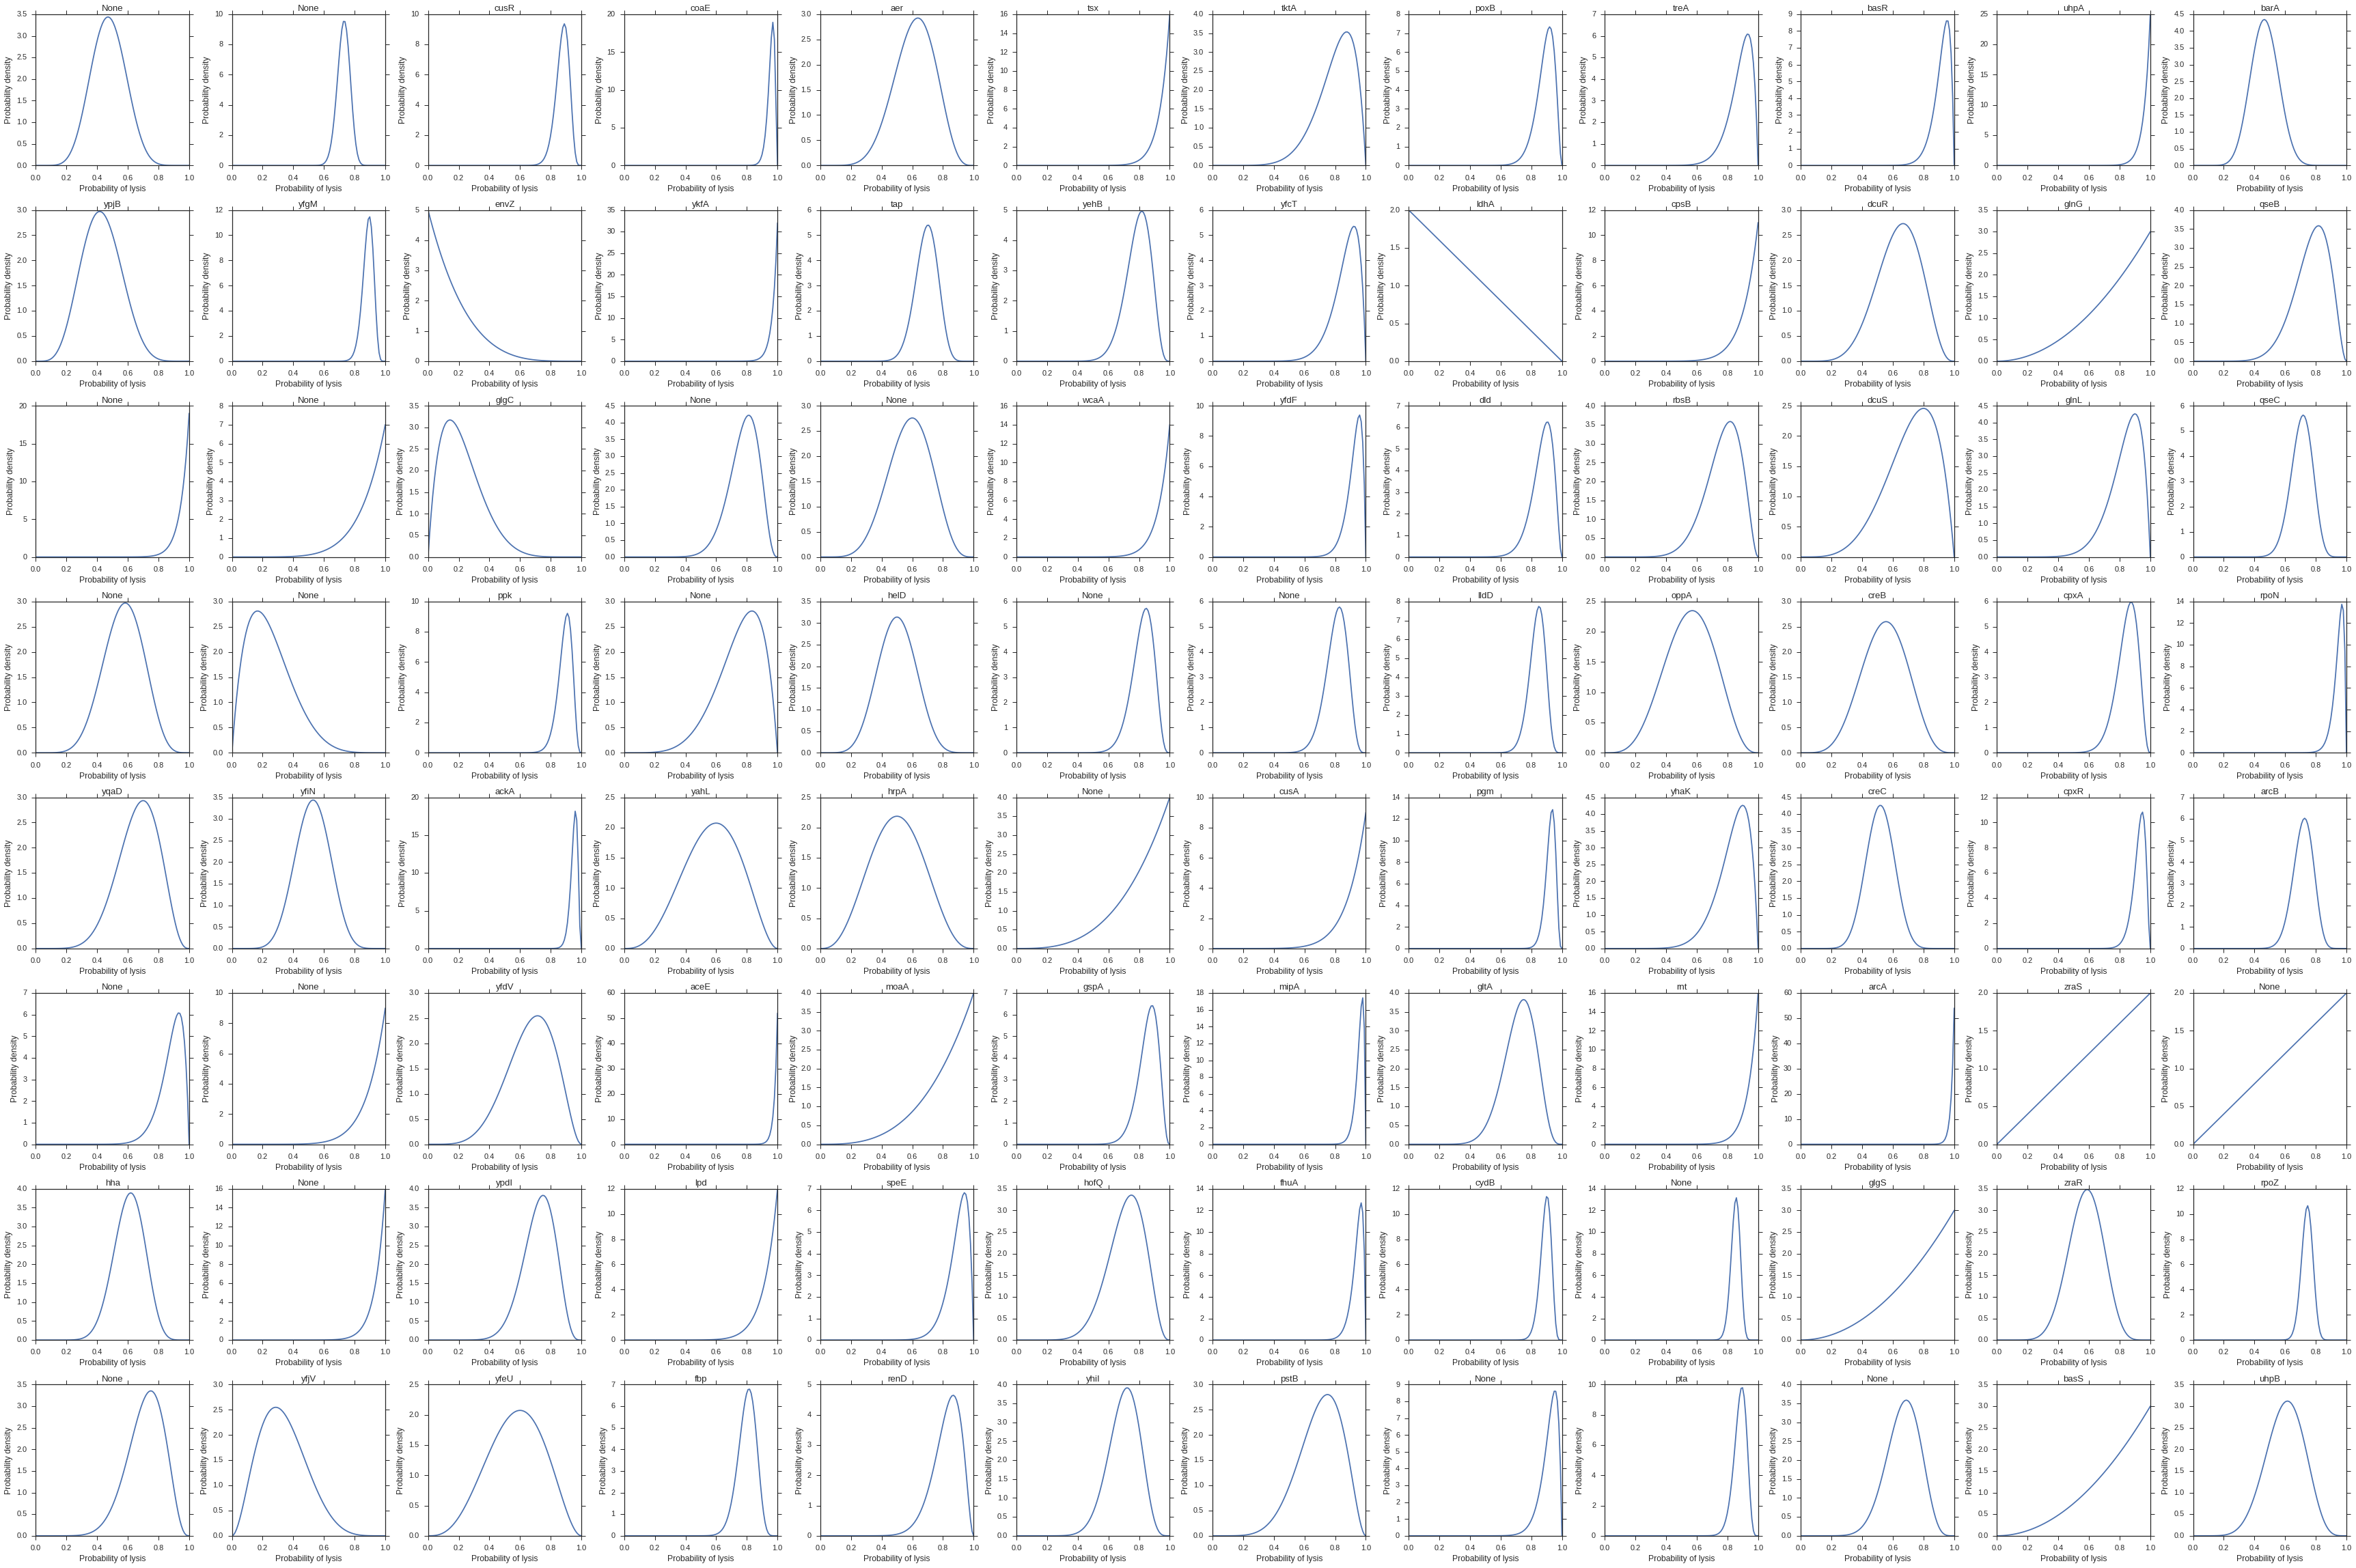

In [9]:
# Use the no phage control to construct a lysis/lysogeny classifier
fitc_control_array = np.array(mean_FITC_control['A1'])
cherry_control_array = np.array(mean_cherry_control['A1'])
kernel_fitc = scipy.stats.gaussian_kde(fitc_control_array)
kernel_cherry = scipy.stats.gaussian_kde(cherry_control_array)

def compute_p_lysis_posterior(N_lysis, N_lysogeny):
    x = np.linspace(0,1,100)
    posterior= scipy.stats.beta.pdf(x, 1+N_lysis, 1+N_lysogeny)
    return x, posterior

# d = classify_infections(kernel_fitc, kernel_cherry, p_values_dict, rows = row_data, cols = col_data)

kn = get_keio_names()
fig, axes = plt.subplots(8,12, figsize = (4*12, 4*8))

for row in row_data:
    for col in col_data:
        well = row + str(col)
        
        well_name = pos_to_strain(kn, plate = plate_number, pos = well)
        p_value = p_values_dict[well]
        infected_cells = np.where(p_value < 0.01)[0]
        fitc_list = np.array(mean_FITC[well])[infected_cells]
        cherry_list = np.array(mean_cherry[well])[infected_cells]

        p_fitc = []
        p_cherry = []
        for fitc, cherry in zip(fitc_list, cherry_list):
            p_fitc += [1-kernel_fitc.integrate_box_1d(fitc, 1e6)]
            p_cherry += [1-kernel_cherry.integrate_box_1d(cherry, 1e6)]

        # Remove double positives
        p_fitc_new = []
        p_cherry_new = []
        fitc_list_new = []
        cherry_list_new = []
        for p_f, p_c, f, c in zip(p_fitc, p_cherry, fitc_list, cherry_list):
            if (p_f < 0.85 and c > 50) or p_c < 0.85:
                p_fitc_new += [p_f]
                p_cherry_new += [p_c]
                fitc_list_new += [f]
                cherry_list_new += [c]

        p_fitc = p_fitc_new
        p_cherry = p_cherry_new
        fitc_list = fitc_list_new
        cherry_list = cherry_list_new

        d = {'FITC Probability': p_fitc, 'Cherry Probability': p_cherry}
        dataframe = pd.DataFrame(data = d)
#         grid = sns.lmplot('FITC Probability', 'Cherry Probability', dataframe, fit_reg = False)
#         ax = grid.axes[0][0]
#         ax.set_title(well_name)
#         ax.set_xlim([-0.05, 1.05])
#         ax.set_ylim([-0.05, 1.05])

        d = {'FITC Intensity': fitc_list, 'Cherry Intensity': cherry_list}
        dataframe = pd.DataFrame(data = d)
#         grid = sns.lmplot('FITC Intensity', 'Cherry Intensity', dataframe, fit_reg = False, scatter_kws = {'color': 'red'})
#         ax = grid.axes[0][0]
#         ax.set_title(well_name)

        counter = 0
        for p_f, p_c in zip(p_fitc, p_cherry):
            if p_f > p_c:
                counter += 1
                
        if len(p_fitc) > 0:
            #Uncomment to print p_lysis
            #print well_name, np.float(counter)/len(p_fitc), counter, len(p_fitc)
            
            x, posterior = compute_p_lysis_posterior(counter, len(p_fitc) - counter)
            
            alphabet = ['A','B','C','D','E','F','G','H']
            chars = list(well)
            row_temp = alphabet.index(chars[0])
            if len(chars) == 2:
                col_temp = int(chars[1])-1
            if len(chars) == 3:
                col_temp = int(chars[1] + chars[2])-1
                
            axes[row_temp, col_temp].plot(x, posterior)
            axes[row_temp, col_temp].set_xlim([0, 1])
            axes[row_temp, col_temp].set_xlabel('Probability of lysis')
            axes[row_temp, col_temp].set_ylabel('Probability density')
            axes[row_temp, col_temp].set_title(well_name)
        else:    
            alphabet = ['A','B','C','D','E','F','G','H']
            chars = list(well)
            row_temp = alphabet.index(chars[0])
            if len(chars) == 2:
                col_temp = int(chars[1])-1
            if len(chars) == 3:
                col_temp = int(chars[1] + chars[2])-1
                
            axes[row_temp, col_temp].plot(x, posterior)
            axes[row_temp, col_temp].set_xlim([0, 1])
            axes[row_temp, col_temp].set_xlabel('Probability of lysis')
            axes[row_temp, col_temp].set_ylabel('Probability density')
            axes[row_temp, col_temp].set_title(well_name)
            
plt.tight_layout()
    

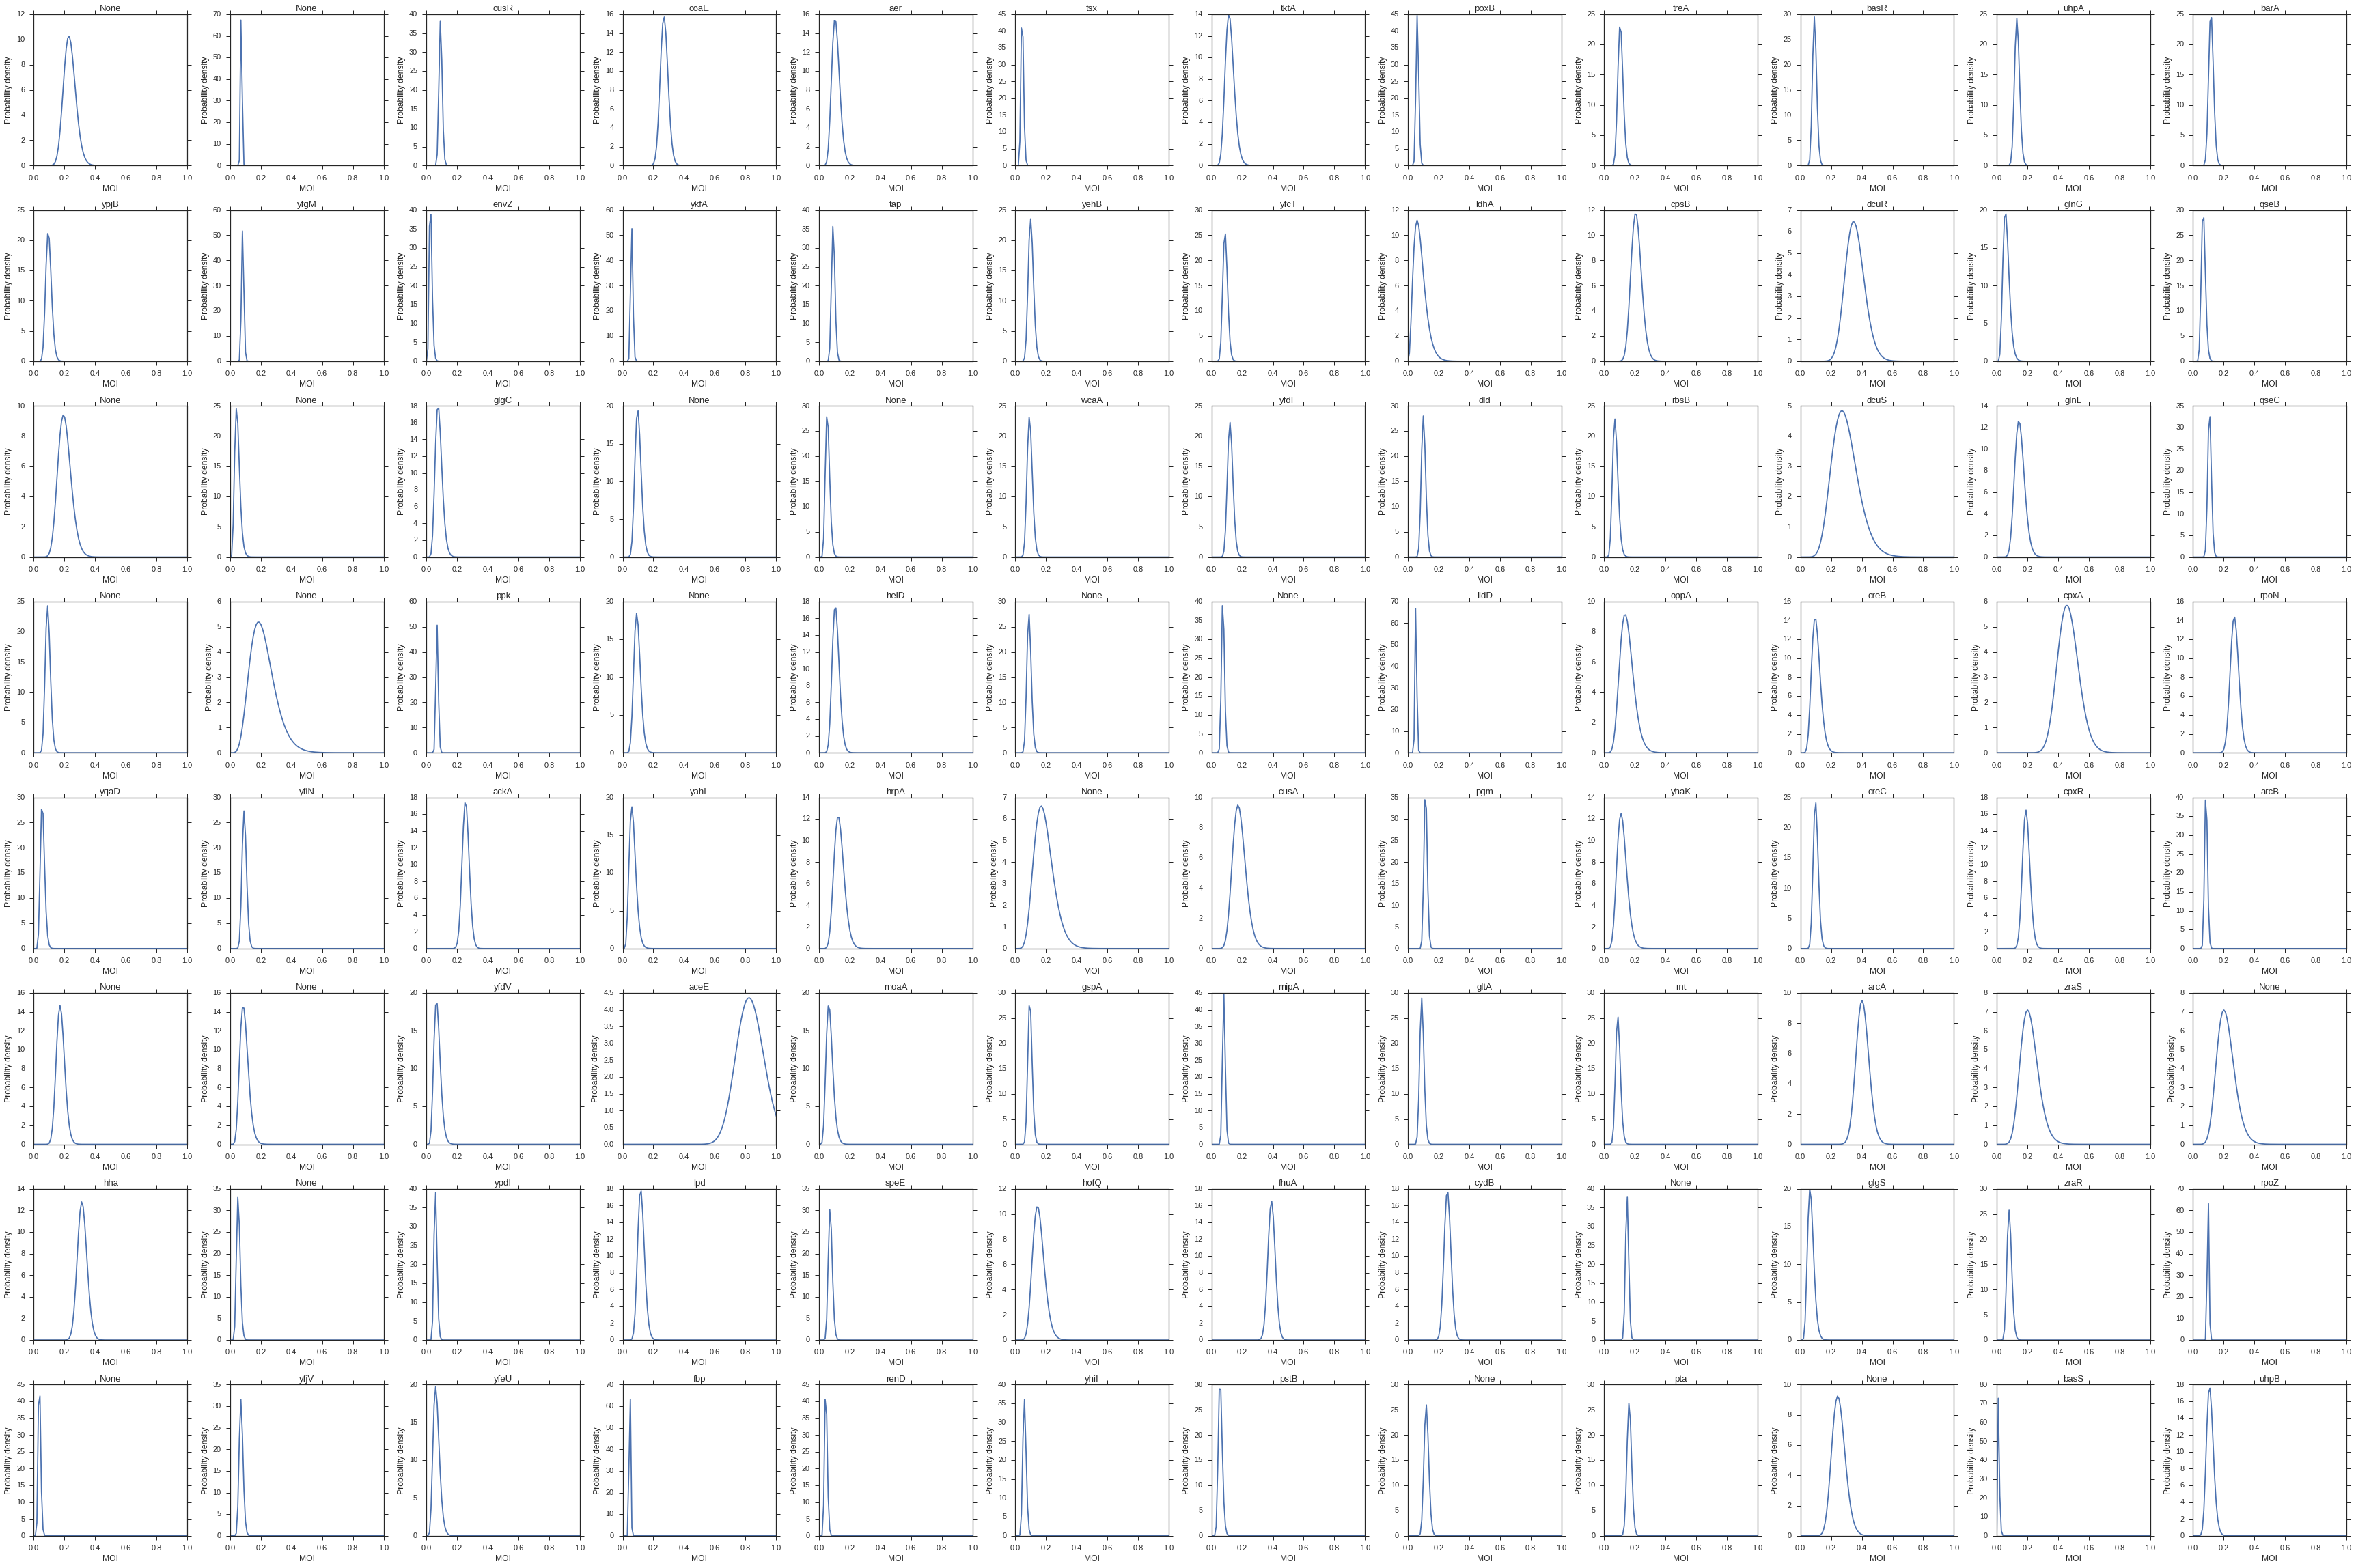

In [10]:
fig, axes = plt.subplots(8,12, figsize = (4*12, 4*8))

def compute_inverse_MOI_posterior(N_infected, N_cells):
    x = np.linspace(0,2,200)
    gamma = np.float(N_cells)*np.log(1-1/np.float(N_cells))
    posterior = np.abs(gamma*np.exp(gamma*x))*scipy.stats.beta.pdf(np.exp(gamma*x), 1+N_cells-N_infected, 1+N_infected)

    return x, posterior

kn = get_keio_names()

for row in row_data:
    for col in col_data:
        well = row + str(col)
        
        well_name = pos_to_strain(kn, plate = plate_number, pos = well)
        p_value = p_values_dict[well]
        infected_cells = np.where(p_value < 0.01)[0]
        fitc_list = np.array(mean_FITC[well])[infected_cells]
        cherry_list = np.array(mean_cherry[well])[infected_cells]

        p_fitc = []
        p_cherry = []
        for fitc, cherry in zip(fitc_list, cherry_list):
            p_fitc += [1-kernel_fitc.integrate_box_1d(fitc, 1e6)]
            p_cherry += [1-kernel_cherry.integrate_box_1d(cherry, 1e6)]

        # Remove double positives
        p_fitc_new = []
        p_cherry_new = []
        fitc_list_new = []
        cherry_list_new = []
        for p_f, p_c, f, c in zip(p_fitc, p_cherry, fitc_list, cherry_list):
            if (p_f < 0.85 and c > 50) or p_c < 0.85:
                p_fitc_new += [p_f]
                p_cherry_new += [p_c]
                fitc_list_new += [f]
                cherry_list_new += [c]

        p_fitc = p_fitc_new
        p_cherry = p_cherry_new
        fitc_list = fitc_list_new
        cherry_list = cherry_list_new

        counter = 0
        for p_f, p_c in zip(p_fitc, p_cherry):
            if p_f > p_c:
                counter += 1
                
        if len(p_fitc) > 0:
            #Uncomment to print p_lysis
            #print well_name, np.float(counter)/len(p_fitc), counter, len(p_fitc)
            x, posterior = compute_inverse_MOI_posterior(infected_cells.shape[0], p_value.shape[0])
            
            alphabet = ['A','B','C','D','E','F','G','H']
            chars = list(well)
            row_temp = alphabet.index(chars[0])
            if len(chars) == 2:
                col_temp = int(chars[1])-1
            if len(chars) == 3:
                col_temp = int(chars[1] + chars[2])-1
                
            axes[row_temp, col_temp].plot(x, posterior)
            axes[row_temp, col_temp].set_xlim([0, 1])
            axes[row_temp, col_temp].set_xlabel('MOI')
            axes[row_temp, col_temp].set_ylabel('Probability density')
            axes[row_temp, col_temp].set_title(well_name)
        else:    
            alphabet = ['A','B','C','D','E','F','G','H']
            chars = list(well)
            row_temp = alphabet.index(chars[0])
            if len(chars) == 2:
                col_temp = int(chars[1])-1
            if len(chars) == 3:
                col_temp = int(chars[1] + chars[2])-1
                
            axes[row_temp, col_temp].plot(x, posterior)
            axes[row_temp, col_temp].set_xlim([0, 1])
            axes[row_temp, col_temp].set_xlabel('MOI')
            axes[row_temp, col_temp].set_ylabel('Probability density')
            axes[row_temp, col_temp].set_title(well_name)
            
plt.tight_layout()